# Importing essential libraries for image data preprocessing, visualization, machine learning, and TensorFlow model development.


In [1]:
import os
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import zipfile
import sklearn.preprocessing as preprocessing

# Unzipping the training and testing datasets from ZIP files into their respective directories.


In [2]:
with zipfile.ZipFile('dogs-vs-cats-redux-kernels-edition/train.zip', 'r') as zip_ref:
    zip_ref.extractall('dogs-vs-cats-redux-kernels-edition/train')


with zipfile.ZipFile('dogs-vs-cats-redux-kernels-edition/test.zip', 'r') as zip_ref:
    zip_ref.extractall('dogs-vs-cats-redux-kernels-edition/test')

# Creating a DataFrame to organize image filenames and their corresponding labels (cat or dog).

In [3]:
image_dir = "dogs-vs-cats-redux-kernels-edition/train/train/"

filenames = os.listdir(image_dir)
labels = [x.split(".")[0] for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels})

data.head()

,filename,label
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


# Splitting the DataFrame into training, testing, and validation sets while ensuring class balance.


In [4]:
# train test split using dataframe

labels = data['label']

X_train, X_temp = train_test_split(data, test_size=0.2, stratify=labels, random_state = 42)

label_test_val = X_temp['label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (20000, 2)
The shape of test data (2500, 2)
The shape of validation data (2500, 2)


# Setting parameters for image size, channels, and batch size for model training.


In [5]:
# parameters
image_size = 64
image_channel = 64
bat_size = 32

# Setting up data generators for image augmentation during training and rescaling for testing.

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'reflect',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)

test_datagen = ImageDataGenerator(rescale=1./255)

# Creating data generators for training, validation, and testing sets, specifying image directory, columns for filenames and labels,
# batch size, and target image size.

In [7]:

train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory = 'dogs-vs-cats-redux-kernels-edition/train/train/',
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size)
                                                   )
val_generator = test_datagen.flow_from_dataframe(X_val, 
                                                 directory = 'dogs-vs-cats-redux-kernels-edition/train/train/',
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False
                                                )

test_generator = test_datagen.flow_from_dataframe(X_test, 
                                                  directory = 'dogs-vs-cats-redux-kernels-edition/train/train/',
                                                  x_col= 'filename',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False
                                                 )

Found 20000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


# Creating a convolutional neural network (CNN) model with multiple layers, including convolutional, max-pooling, dropout, and fully connected layers.


In [8]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_size,image_size,image_channel))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Bloack 1 
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fully Connected layers 
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        18464     
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 64)       2

# Setting up early stopping to monitor the validation loss during training and restore the best model weights if no improvement after 3 epochs.

In [9]:
early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)

# Compiling the model with the Adam optimizer, binary cross-entropy loss (for binary classification), and accuracy as the evaluation metric.

In [10]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# Training the model using the training data generator, validating it on the validation data generator, and implementing early stopping with a maximum of 5 epochs.


In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)

# Modify the input shape of the first Conv2D layer
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, image_channel))) 

cat_dog = model.fit(train_generator,
                    validation_data=val_generator, 
                    callbacks=[early_stopping],
                    epochs=5,
                    batch_size=32,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(val_generator),
                   )

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node 'sequential/conv2d/Relu' defined at (most recent call last):
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\user\AppData\Local\Temp\ipykernel_9320\503016471.py", line 3, in <module>
      cat_dog = model.fit(train_generator,
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\convolutional\base_conv.py", line 321, in call
      return self.activation(outputs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'sequential/conv2d/Relu'
input depth must be evenly divisible by filter depth: 3 vs 64
	 [[{{node sequential/conv2d/Relu}}]] [Op:__inference_train_function_3429]

# Saving the trained model to a file named "model1.h5".

In [ ]:
model.save("model1.h5")

NameError: name 'model' is not defined

In [ ]:


# Plotting the training and validation accuracy over epochs to visualize the model's performance.

In [ ]:
history = cat_dog

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'cat_dog' is not defined

# Plotting the training and validation loss over epochs to visualize the model's performance.

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'plt' is not defined

# Creating a simplified convolutional neural network (CNN) model with multiple layers, including convolutional and max-pooling layers, without batch normalization and dropout for simplicity.

In [12]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_size,image_size,image_channel))) 
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))

# Bloack 1 
model.add(Conv2D(64,(3,3),activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))
# Block 2
model.add(Conv2D(128,(3,3),activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))
# Block 3
model.add(Conv2D(256,(3,3),activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))

# Fully Connected layers 
model.add(Flatten())
model.add(Dense(512,activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# Output layer
model.add(Dense(2,activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 128)       

# Setting up early stopping to monitor the validation loss during training and restore the best model weights if no improvement after 3 epochs. 

In [13]:
early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)

# Compiling the model with the Adam optimizer, categorical cross-entropy loss (for multiclass classification), and accuracy as the evaluation metric.


In [14]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# Training the model using the training data generator, validating it on the validation data generator, and implementing early stopping with a maximum of 3 epochs.

In [17]:
# Modify the input shape of the first Conv2D layer
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, image_channel)))


Epoch 1/3


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_1/conv2d_4/Relu' defined at (most recent call last):
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\user\AppData\Local\Temp\ipykernel_9320\1372732608.py", line 1, in <module>
      cat_dog = model.fit(train_generator,
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\convolutional\base_conv.py", line 321, in call
      return self.activation(outputs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'sequential_1/conv2d_4/Relu'
input depth must be evenly divisible by filter depth: 3 vs 64
	 [[{{node sequential_1/conv2d_4/Relu}}]] [Op:__inference_train_function_5148]

# Saving the trained model to a file named "model2.h5".

In [ ]:
model.save("model2.h5")

NameError: name 'model' is not defined

# Loading a previously trained model from the file "model1.h5".

In [ ]:
model = load_model("model1.h5")

NameError: name 'load_model' is not defined

# Using the trained model to make predictions on the test data using the test data generator.

In [ ]:
Y_pred = model.predict(test_generator)

NameError: name 'model' is not defined

# Encoding the labels of the test data using a LabelEncoder to prepare them for evaluation.

In [ ]:
label_encoder = preprocessing.LabelEncoder()

# Fit the encoder to the data and transform the data
encoded = label_encoder.fit_transform(X_test.label)

print(encoded)

NameError: name 'preprocessing' is not defined

# Converting the predicted probabilities into class labels by selecting the class with the highest probability for each prediction.

In [ ]:
Y_pred = np.argmax(Y_pred,axis =1)

NameError: name 'np' is not defined

# Defining a function to calculate and visualize the confusion matrix, sensitivity, and specificity of the model's predictions.

In [18]:
def confusion(Y_pred_reverse,Y_test_reverse):
    cm = confusion_matrix(Y_test_reverse, Y_pred_reverse)
    cm_percent = cm / cm.sum(axis=1).reshape(-1, 1) * 100
    sns.heatmap(cm_percent, annot=True, cmap="Blues")
    plt.title("Confusion Matrix (Percentage)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.show()

    sensitivity = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    print("Sensitivity: {0:.2f}".format(sensitivity))
confusion(Y_pred,encoded)

NameError: name 'Y_pred' is not defined

# Displaying an example image from the specified image directory using Matplotlib.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(image_dir+"dog.8022.jpg")
fig, ax = plt.subplots()
ax.imshow(img)


NameError: name 'image_dir' is not defined

# Iterating through the predictions and true labels to identify and print the indices where the predictions differ from the encoded labels.


# Accessing and displaying the data at a specific index (index 217) from the test dataset (X_test).


In [ ]:
for i in range(len(Y_pred)):
    if Y_pred[i]!=encoded[i]:
        print(i)

In [ ]:
X_test.iloc[217]

NameError: name 'X_test' is not defined

# Calculating the macro-average F1 score to evaluate the model's overall performance on the test dataset.


In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(y_true=encoded, y_pred=Y_pred, average='macro')
print("F1 SCORE :" ,f1)

NameError: name 'encoded' is not defined

# Calculating the Receiver Operating Characteristic Area Under Curve (ROC AUC) score to assess the model's classification performance.

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(encoded, Y_pred)

In [ ]:
print(roc_auc)

0.906


# Creating a layered view of the neural network model using VisualKeras for visualization, including a legend.


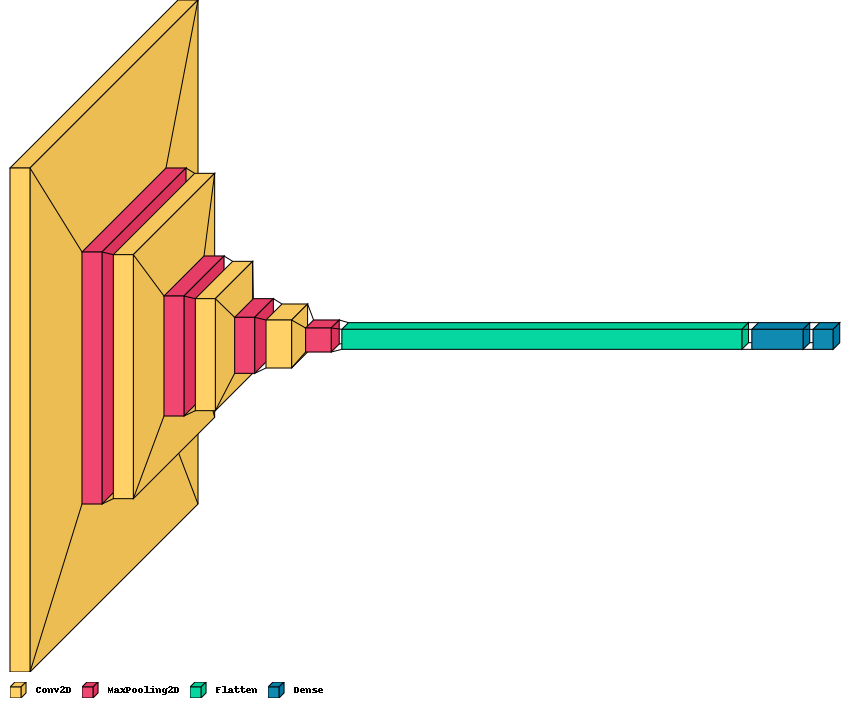

In [ ]:
import visualkeras
visualkeras.layered_view(model=model,legend=True)